# Noise2Void - 3D Example

In [2]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.
/home/jmamede/anaconda3/envs/n2v/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jmamede/anaconda3/envs/n2v/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jmamede/anaconda3/envs/n2v/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jmamede/anaconda3/en

# Download Example Data
Thanks to Romina Piscitello (Eaton Lab, MPI-CBG) for letting us use her data.

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath='data/flywing-data.zip'
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/RKStdwKo4FlFrxE/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall('data')

# Training Data Preparation
For training we will load __one__ low-SNR 3D-tif-volume and use the <code>N2V_DataGenerator</code> to extract non-overlapping 3D-patches. Since N2V is a self-supervised method, we don't need targets.

In [3]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [12]:
# We will load all the '.tif' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
imgs = datagen.load_imgs_from_directory(directory = "data/", dims='ZYX')

# Let's look at the shape of the image
print(imgs[0].shape)
print(len(imgs))
# The function automatically added two extra dimension to the images:
# One at the front is used to hold a potential stack of images such as a movie.
# One at the end could hold color channels such as RGB.

(1, 35, 520, 692, 1)
1


In [16]:
len(imgs)

1

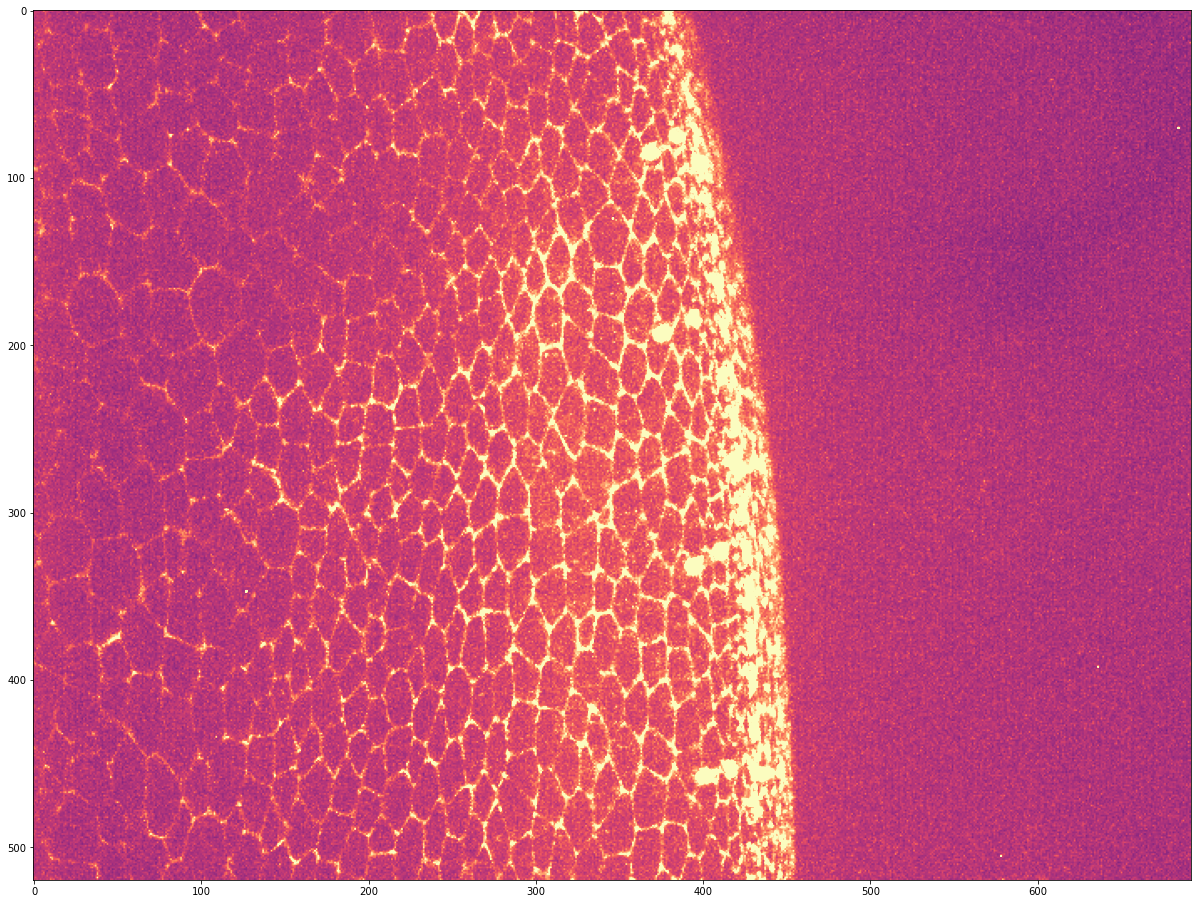

In [5]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

In [6]:
# Here we extract patches for training and validation.
patch_shape = (32, 64, 64)
patches = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape)

Generated patches: (640, 32, 64, 64, 1)


In [17]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:600]
X_val = patches[600:]

In [4]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

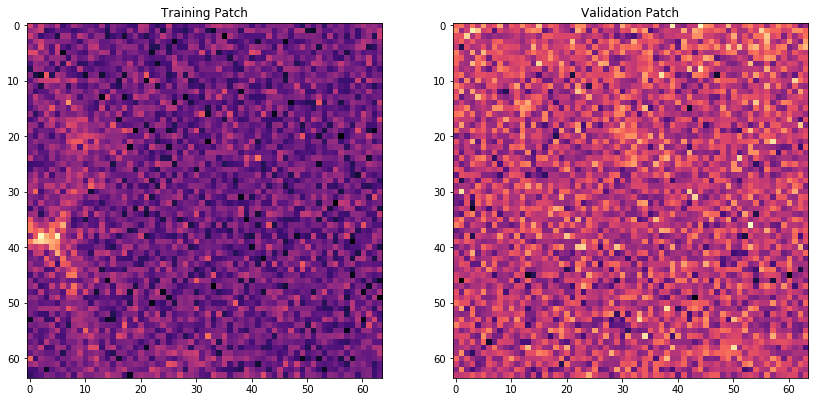

In [9]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,16,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,16,...,0],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [10]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(32, 64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['37.058723'],
 'stds': ['5.36331'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 4,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (32, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'structN2Vmask': None,
 'probabilistic': False}

In [11]:
# a name used to identify the model
model_name = 'n2v_3D'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

/home/tbuchhol/Gitrepos/n2v/n2v/models/n2v_standard.py:428: UserWarning: output path for model already exists, files may be overwritten: /home/tbuchhol/Gitrepos/n2v/examples/3D/models/n2v_3D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training

In [12]:
history = model.train(X, X_val)

Preparing validation data: 100%|██████████| 40/40 [00:00<00:00, 1782.08it/s]

259 blind-spots will be generated per training patch of size (32, 64, 64).


Epoch 1/20
4/4 [==============================] - 5s 1s/step - loss: 2.9560 - n2v_mse: 2.9560 - n2v_abs: 1.1833 - val_loss: 1.7679 - val_n2v_mse: 1.7679 - val_n2v_abs: 1.0057
Epoch 2/20
4/4 [==============================] - 1s 363ms/step - loss: 1.8319 - n2v_mse: 1.8319 - n2v_abs: 1.0995 - val_loss: 3.2964 - val_n2v_mse: 3.2964 - val_n2v_abs: 1.2493
Epoch 3/20
4/4 [==============================] - 1s 363ms/step - loss: 1.8078 - n2v_mse: 1.8078 - n2v_abs: 1.0886 - val_loss: 4.5378 - val_n2v_mse: 4.5378 - val_n2v_abs: 1.3870
Epoch 4/20
4/4 [==============================] - 1s 364ms/step - loss: 1.4096 - n2v_mse: 1.4096 - n2v_abs: 0.9956 - val_loss: 8.1071 - val_n2v_mse: 8.1071 - val_n2v_abs: 1.7828
Epoch 5/20
4/4 [==============================] - 1s 365ms/step - loss: 1.0752 - n2v_mse: 1.0752 - n2v_abs: 0.8238 - val_loss: 11.5974 - val_n2v_mse: 11.5974 - val_n2v_abs: 2.1289
Epoch 6/20
4/4 [==============================] - 1s 366ms/step - loss: 1.2582 - n2v_mse: 1.2582 - n2v_abs: 0.8

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


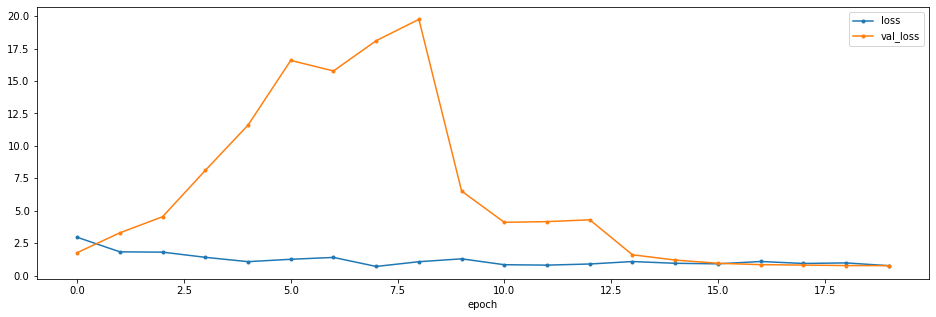

In [13]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [14]:
model.export_TF(name='Noise2Void - 3D Example', 
                description='This is the 3D Noise2Void example trained in python.', 
                authors=["Tim-Oliver Buchholz", "Alexander Krull", "Florian Jug"],
                test_img=X_val[0,...,0], axes='ZYX',
                patch_shape=patch_shape)

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpvu4yr6mg/model/saved_model.pb

Model exported in BioImage ModelZoo format:
/home/tbuchhol/Gitrepos/n2v/examples/3D/models/n2v_3D/export.bioimage.io.zip
